In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import scipy.stats as stats
import csv
%matplotlib inline

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

oFile = '/content/drive/My Drive/Grad School/oSpam.csv'
uFile = '/content/drive/My Drive/Grad School/uSpam.csv'
fields = ['v1','v2', '', '', '']
spam = []
ham = []

with open('/content/drive/My Drive/Grad School/spam.csv', 'r', encoding="ISO-8859-1") as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
    if row[0] == 'ham':
      ham.append(row)
    elif row[0] == 'spam':
      spam.append(row)

In [0]:
oList = []
for row in ham:
  oList.append(row)
for i in range(7):
  for row in spam:
    oList.append(row)

hamCopy = ham[:750]
uList = []
for row in hamCopy:
  uList.append(row)
for row in spam:
  uList.append(row)

In [0]:
with open(oFile, 'w', encoding="latin-1") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(oList)

with open(uFile, 'w', encoding="latin-1") as csvfile:
    csvwriter = csv.writer(csvfile)   
    csvwriter.writerow(fields) 
    csvwriter.writerows(uList) 

In [74]:
df = pd.read_csv('/content/drive/My Drive/Grad School/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [75]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [76]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

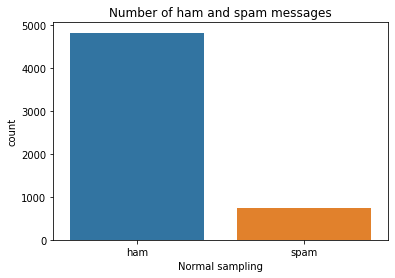

In [77]:
sns.countplot(df.v1)
plt.xlabel('Normal sampling')
plt.title('Number of ham and spam messages')

In [0]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [82]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [83]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.3184 - accuracy: 0.8823 - val_loss: 0.1508 - val_accuracy: 0.9662
Epoch 2/10
3788/3788 [==============================] - 8s 2ms/step - loss: 0.0763 - accuracy: 0.9828 - val_loss: 0.0758 - val_accuracy: 0.9789
Epoch 3/10
3788/3788 [==============================] - 8s 2ms/step - loss: 0.0366 - accuracy: 0.9865 - val_loss: 0.0726 - val_accuracy: 0.9831
Epoch 4/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.0801 - val_accuracy: 0.9842


In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [85]:
accr = model.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - 1s 658us/step


In [86]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.064
  Accuracy: 0.984


In [87]:
odf = pd.read_csv('/content/drive/My Drive/Grad School/oSpam.csv',delimiter=',',encoding="ISO-8859-1")
odf.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
3,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
4,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN


In [88]:
odf['v1'].value_counts()

spam    5229
ham     4825
Name: v1, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

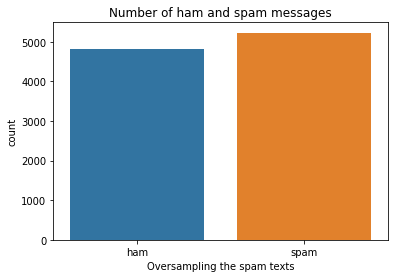

In [89]:
sns.countplot(odf.v1)
plt.xlabel('Oversampling the spam texts')
plt.title('Number of ham and spam messages')

In [0]:
X = odf.v2
Y = odf.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [91]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 6836 samples, validate on 1709 samples
Epoch 1/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.4704 - accuracy: 0.8204 - val_loss: 0.1821 - val_accuracy: 0.9350
Epoch 2/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.0958 - accuracy: 0.9655 - val_loss: 0.1038 - val_accuracy: 0.9672
Epoch 3/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.1029 - accuracy: 0.9772 - val_loss: 0.0537 - val_accuracy: 0.9848
Epoch 4/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0479 - val_accuracy: 0.9877
Epoch 5/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0465 - val_accuracy: 0.9877
Epoch 6/10
6836/6836 [==============================] - 14s 2ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.0355 - val_accuracy: 0.9912
Epoch 7/10
6836/6836 [==============================] - 13s 2ms/step - loss: 0.010

In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [93]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1509/1509 [==============================] - 1s 801us/step
Test set
  Loss: 0.020
  Accuracy: 0.993


In [94]:
udf = pd.read_csv('/content/drive/My Drive/Grad School/uSpam.csv',delimiter=',',encoding="ISO-8859-1")
udf.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
3,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
4,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN


In [100]:
udf['v1'].value_counts()

ham     750
spam    747
Name: v1, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

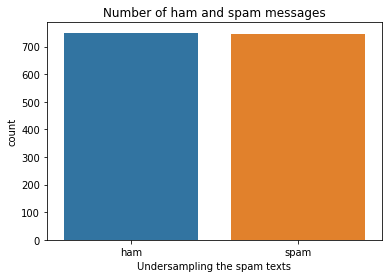

In [96]:
sns.countplot(udf.v1)
plt.xlabel('Undersampling the spam texts')
plt.title('Number of ham and spam messages')

In [0]:
X = udf.v2
Y = udf.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [98]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1017 samples, validate on 255 samples
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 1.4467 - accuracy: 0.6578 - val_loss: 0.9685 - val_accuracy: 0.6980
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.5773 - accuracy: 0.7827 - val_loss: 0.6066 - val_accuracy: 0.7608
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3834 - accuracy: 0.8397 - val_loss: 0.4687 - val_accuracy: 0.8157
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3095 - accuracy: 0.8820 - val_loss: 0.3821 - val_accuracy: 0.8510
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.2460 - accuracy: 0.9046 - val_loss: 0.3415 - val_accuracy: 0.8706
Epoch 6/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.1851 - accuracy: 0.9351 - val_loss: 0.2878 - val_accuracy: 0.9020
Epoch 7/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.1431 - accu

In [99]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

225/225 [==============================] - 0s 1ms/step
Test set
  Loss: 0.185
  Accuracy: 0.947
